In [1]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import cross_val_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\vajrak\Anaconda3\envs\ztdl\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\vajrak\Anaconda3\envs\ztdl\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#Extracting the data from database table
conn=sqlite3.connect('database.sqlite')
filtered_data=pd.read_sql_query('select * from Reviews where Score!=3',conn)
print(filtered_data.head())
print(filtered_data.shape)

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [3]:
#Changing the Score column with Positive(Rating 4 and 5) and negative(rating 1 and 2)
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'
dub_score=filtered_data['Score']
positivenegative=dub_score.map(partition)
filtered_data['Score']=positivenegative

In [4]:
#first 5 rows of data after changing the score column
print(filtered_data.shape)
filtered_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:

#sorting the data before removing duplicates
sorted_data=filtered_data.sort_values('ProductId',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [6]:
#drop_duplicates
final=sorted_data.drop_duplicates(subset={'ProfileName','UserId','Time','Text'},keep='first',inplace=False)
print(final.shape)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364173, 10)


(364171, 10)

In [7]:
final['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [8]:
import re
i=0
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(sent)
        break
    i+=1
print(i)

I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.
6


In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'he', 'hasn', 'each', 'but', 're', 'we', 'ain', 'most', 'or', 'and', 'shouldn', 'me', 'it', 'your', 'some', 'aren', 'mustn', "didn't", 'its', 'doing', "shan't", 'more', 'before', "doesn't", 'whom', 'do', 'than', "haven't", 's', 'you', "won't", 'not', 'didn', 'doesn', "hadn't", 'him', 'over', 'about', "should've", "mustn't", 'they', "you're", 'now', "hasn't", 'been', 'be', 'until', 'there', 'can', 'having', 'same', 'o', "mightn't", 'were', 'when', 'up', "couldn't", 'that', "aren't", 'between', 'don', 'being', 'then', 'with', 'hers', 'during', 'shan', 'so', 'further', 'after', "weren't", 'ourselves', 'her', 't', 'does', 'which', 'very', 'mightn', 'other', 'had', 'wouldn', "you've", 'all', 'is', 'are', 'through', "it's", 'a', 'such', 'yourselves', 'd', 'them', 'off', 'out', 'against', 'of', "you'd", 'itself', 'at', 'while', 'from', 'because', 'again', 'herself', 'to', 'himself', 'our', 'my', 'into', 'have', 'am', 'by', 'under', 'any', 'down', "she's", 'll', "shouldn't", 'above', 'was', '

In [10]:
i=0
str1=' '
final_string=[]
all_positive_words=[]
all_negative_words=[] 
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split(): #remove puncuations
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

In [11]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")
final.head()
print(final.shape)

(364171, 11)


In [12]:
#storing the cleaned data in the form of sql table for furthur use
conn = sqlite3.connect('finalss.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviewwss',conn,schema=None,if_exists='replace',index=True,index_label=None,chunksize=None,dtype=None)

In [13]:
#reading or extracting the newly stored sql table and we will be using same throughtout our analysis
con=sqlite3.connect('finalss.sqlite')
cleaned_data=pd.read_sql_query('select * FROM Reviewwss',con)
cleaned_data.shape

(364171, 12)

In [14]:
#randomly sampling set of positive and neagative reviews from our dataset and concatinate them
positive_sample=cleaned_data[cleaned_data['Score'].values=='positive'].sample(n=10000)
negative_sample=cleaned_data[cleaned_data['Score']=='negative'].sample(n=10000)
final_data=pd.concat([positive_sample,negative_sample])
final_data.shape

(20000, 12)

In [15]:
#sorting the data with time
final_data['Time']=pd.to_datetime(final_data['Time'],unit='s')
final_data=final_data.sort_values(by='Time')

In [16]:
#Bag of words 
#function for best-k value
def k_classifier(X_train,y_train):
    mylist=list(range(0,50))
    neighbors=list(filter(lambda x: x % 2 != 0,mylist))
    cv_scores=[]
    
    for k in neighbors:
        knn=KNeighborsClassifier(n_neighbors=k,algorithm='brute')
        scores=cross_val_score(knn,X_train,y_train,cv=10,scoring='accuracy')
        cv_scores.append(scores.mean())
    MSE=[1-x for x in cv_scores]
    best_k=neighbors[MSE.index(min(MSE))]
    print('best_k is',best_k)
    #ploting k VS MSE
    plt.plot(neighbors,MSE)
    for xy in zip(neighbors,np.round(MSE,3)):
        plt.annotate('(%s,%s)'% xy,xy=xy,textcoords='data')
    plt.title('MSE vs k')
    plt.xlabel('K-values')
    plt.ylabel('MSE')
    plt.show()
    print("mis-classification error is",np.round(MSE,3))
    return best_k

In [1]:
X=final_data['CleanedText']
X

NameError: name 'final_data' is not defined

In [18]:
Y=final_data['Score']

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
print(X_train.shape,y_train.shape,y_test.shape,X_test.shape)

(14000,) (14000,) (6000,) (6000,)


In [20]:
# training our data with bag of words
bow=CountVectorizer()
X_train=bow.fit_transform(X_train)
X_train

<14000x15674 sparse matrix of type '<class 'numpy.int64'>'
	with 451766 stored elements in Compressed Sparse Row format>

In [21]:

#applying out fit model to test data 
X_test=bow.transform(X_test)
X_test.shape

(6000, 15674)

best_k is 47


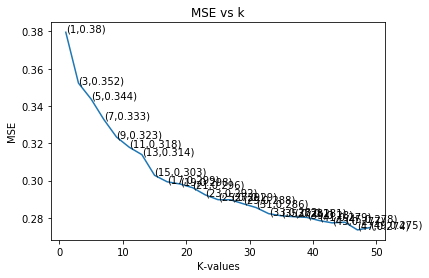

mis-classification error is [ 0.38   0.352  0.344  0.333  0.323  0.318  0.314  0.303  0.299  0.298
  0.296  0.292  0.29   0.29   0.288  0.286  0.282  0.281  0.281  0.28
  0.279  0.277  0.278  0.274  0.275]


47

In [22]:
#finding the best k
best_k=k_classifier(X_train,y_train)
best_k

In [23]:
#training our data with KNN
bow_data=KNeighborsClassifier(best_k)
bow_data.fit(X_train,y_train)
pred=bow_data.predict(X_test)

In [24]:
Score=bow_data.score(X_train,y_train)
print('train accuracy is',Score)
train_error=1-Score
print('train error is',train_error)

train accuracy is 0.752571428571
train error is 0.247428571429


In [25]:
#predicting the acuracy on unseen test data
bow_accuracy=accuracy_score(pred,y_test)*100
print("bow accuracy for k=%d is %f%%" %(best_k,bow_accuracy))

bow accuracy for k=47 is 72.383333%


In [26]:
#Tf-idf
X=final_data['CleanedText']
Y=final_data['Score']
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(14000,) (6000,) (14000,) (6000,)


In [27]:
tf_idf_vect=TfidfVectorizer()
X_train_tfidf=tf_idf_vect.fit_transform(X_train)
X_train_tfidf

<14000x15674 sparse matrix of type '<class 'numpy.float64'>'
	with 451766 stored elements in Compressed Sparse Row format>

In [28]:
X_test_tfidf=tf_idf_vect.transform(X_test)
X_test_tfidf

<6000x15674 sparse matrix of type '<class 'numpy.float64'>'
	with 191274 stored elements in Compressed Sparse Row format>

best_k is 49


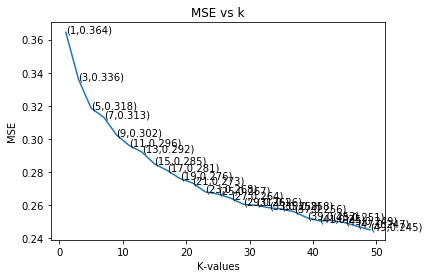

mis-classification error is [ 0.364  0.336  0.318  0.313  0.302  0.296  0.292  0.285  0.281  0.276
  0.273  0.268  0.267  0.264  0.26   0.26   0.258  0.258  0.256  0.252
  0.25   0.251  0.249  0.247  0.245]


49

In [29]:
optimal_k=k_classifier(X_train_tfidf,y_train)
optimal_k

In [30]:
optimal_k=KNeighborsClassifier(best_k)
optimal_k.fit(X_train_tfidf,y_train)
pred=optimal_k.predict(X_test_tfidf)

In [31]:
train_accuracy=optimal_k.score(X_train_tfidf,y_train)
print('train_accuracy is',train_accuracy)
trainerror=1-train_accuracy
print('train_error is',trainerror)

train_accuracy is 0.775357142857
train_error is 0.224642857143


In [32]:
test_accuracy=accuracy_score(pred,y_test)
print('test_accuracy is',test_accuracy)
test_error=1-test_accuracy
print('test_error is',test_error)

test_accuracy is 0.750666666667
test_error is 0.249333333333


In [33]:
#word2vec
X=final_data['Text'].values
X.shape

(20000,)

In [34]:

Y=final_data['Score'].values
Y.shape

(20000,)

In [35]:
cleaned_final=[]
for sent in X:
    cleaned_str=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for w in cleanpunc(w).split():
            if((w.isalpha())&(len(w)>2)):
                cleaned_str.append(w.lower())
            else:
                continue
    cleaned_final.append(cleaned_str)
final_data['cleanedText1']=cleaned_final
X1=final_data['cleanedText1']

In [36]:
X_train,X_test,y_train,y_test=train_test_split(X1,Y,test_size=0.3,random_state=42)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(14000,) (6000,) (14000,) (6000,)


In [37]:

w2v_model=Word2Vec(X_train,size=50,workers=4,min_count=5)

In [38]:
w2v_words = list(w2v_model.wv.vocab)
len(w2v_words)

7696

In [39]:
#Avg-w2v for train data
sent_vectors=[]
for sent in X_train:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

14000
50


In [40]:
#Avg-w2v for test data
sent_vectors_test=[]
for sent in X_test:
    sent_vec=np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            sent_vec+=vec
            cnt_words+=1
    if cnt_words!=0:
        sent_vec/=cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

6000
50


In [41]:
X_train=sent_vectors
len(X_train)

14000

In [42]:
X_test=sent_vectors_test
len(X_test)

6000

best_k is 47


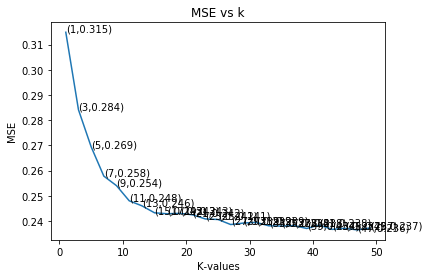

mis-classification error is [ 0.315  0.284  0.269  0.258  0.254  0.248  0.246  0.243  0.243  0.243
  0.242  0.241  0.241  0.239  0.239  0.239  0.238  0.238  0.238  0.237
  0.238  0.237  0.237  0.236  0.237]


In [43]:
optimalk=k_classifier(X_train,y_train)

In [44]:

optimalk_r=KNeighborsClassifier(optimalk)
optimalk_r.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=47, p=2,
           weights='uniform')

In [45]:
pred=optimalk_r.predict(X_test)

In [46]:
train_accuracy=optimalk_r.score(X_train,y_train)
print('avg Word2vec train accuracy is',train_accuracy)

avg Word2vec train accuracy is 0.776785714286


In [47]:
test_accuracy=accuracy_score(pred,y_test)
print('test_accuracy of Avgw2v is',test_accuracy)

test_accuracy of Avgw2v is 0.764


In [48]:
#tf-idf-weightedw2v
tf_idf_feat=tf_idf_vect.get_feature_names()
tf_idf_sent_vec=[]
row=0
for sent in X_train:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            tf_idf=X_train_tfidf[row,tf_idf_feat.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    sent_vec/=weight_sum
    tf_idf_sent_vec.append(sent_vec)
    row+=1
len(tf_idf_sent_vec)

14000

In [49]:
X_train_weightedtrain=tf_idf_sent_vec
len(X_train_weightedtrain)

14000

In [51]:
X_train_w=np.nan_to_num(X_train_weightedtrain)
len(X_train)

14000

best_k is 5


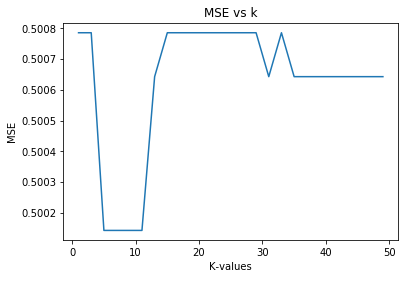

mis-classification error is [ 0.501  0.501  0.5    0.5    0.5    0.5    0.501  0.501  0.501  0.501
  0.501  0.501  0.501  0.501  0.501  0.501  0.501  0.501  0.501  0.501
  0.501  0.501  0.501  0.501  0.501]


In [52]:
optimal_k_weighted=k_classifier(X_train_w,y_train)

In [53]:
optimal_k_w=KNeighborsClassifier(optimal_k_weighted)
optimal_k_w.fit(X_train_w,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [54]:
train_accuracy1=optimal_k_w.score(X_train_w,y_train)
print('tf-idf-weighted Word2vec train accuracy is',train_accuracy1)

tf-idf-weighted Word2vec train accuracy is 0.499214285714


In [55]:
tf_idf_feat=tf_idf_vect.get_feature_names()
tf_idf_sent_vec=[]
row=0
for sent in X_test:
    sent_vec=np.zeros(50)
    weight_sum=0
    for word in sent:
        if word in w2v_words:
            vec=w2v_model.wv[word]
            tf_idf=X_test_tfidf[row,tf_idf_feat.index(word)]
            sent_vec+=(vec*tf_idf)
            weight_sum+=tf_idf
    sent_vec/=weight_sum
    tf_idf_sent_vec.append(sent_vec)
    row+=1

In [56]:
X_test_w=tf_idf_sent_vec
len(X_test_w)

6000

In [57]:
X_test_f=np.nan_to_num(X_test_w)
len(X_test_f)

6000

In [58]:
pred=optimal_k_w.predict(X_test_f)

In [59]:
test_accuracy_weightedtfidf=accuracy_score(pred,y_test)
print("test accuracy of tf-idf weighted w2v is",test_accuracy_weightedtfidf)

test accuracy of tf-idf weighted w2v is 0.501833333333
